In [1]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from random import randrange
from wordcloud import WordCloud

In [22]:
# Baixar recursos do NLTK (se necessário)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('portuguese')
stop_words.append('que')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def remover_palavras_exatas(texto: str, palavras: list[str]) -> str:
    """
    Remove palavras exatas do texto usando regex, sem remover substrings.

    Args:
        texto (str): Texto de entrada.
        palavras (list[str]): Lista de palavras a remover (exatamente).

    Returns:
        str: Texto com as palavras removidas.
    """
    for palavra in palavras:
        # Remove a palavra com delimitador de palavra (\b) e insensível a maiúsculas
        padrao = rf'\b{re.escape(palavra)}\b'
        texto = re.sub(padrao, '', texto, flags=re.IGNORECASE)

    # Limpa múltiplos espaços e espaços antes de pontuação
    texto = re.sub(r'\s{2,}', ' ', texto)
    texto = re.sub(r'\s+([,.!?;:])', r'\1', texto)

    return texto.strip()

In [25]:
# 2. Pré-processamento (corrigido) [99%]
import unicodedata

def clean_text(text):
    '''
    Perform stop-words removal and lemmatization
    '''

    text = text.lower()

    text_normalize = unicodedata.normalize("NFD", text)
    text = ''.join(
        char for char in text_normalize
        if not unicodedata.combining(char)
    )

    text = re.sub(r"[^a-zA-Z?.!,¿]+|http\S+", " ", text)

    not_punctuation_text = ""
    for char in text:
        if char not in string.punctuation:
            not_punctuation_text += char
        else:
            not_punctuation_text += " "
    text = not_punctuation_text

    words = [word for word in text.split() if word not in stop_words ]
    words = [WordNetLemmatizer().lemmatize(word) for word in words]

    return " ".join(words)

In [6]:
# 2.1. Data Frame Treatment & Training and Matching Separation [30% ainda quero estudar melhor]
import pandas as pd
import re
from sklearn.model_selection import train_test_split

def load_and_prepare_data(filepath):
    """Carrega e prepara os dados"""
    # Carregar dados
    df_TextLabel = pd.read_csv(filepath)

    # Limpar textos
    df_TextLabel['cleaned_text'] = df_TextLabel['comentario'].apply(clean_text)

    # Filtrar colunas necessárias
    df_TextLabel = df_TextLabel[['cleaned_text', 'label_final']]
    df_TextLabel.columns = ['text', 'label']

    # Remover linhas vazias
    df_TextLabel = df_TextLabel.dropna()
    df_TextLabel = df_TextLabel[df_TextLabel['text'] != '']

    return df_TextLabel

def split_data(df_TextLabel):
    """Divide os dados em treino e teste"""
    text_var = df_TextLabel['text']
    label_var = df_TextLabel['label']
    return train_test_split(text_var, label_var, test_size=0.2, random_state=42)

file_path = '/content/HateBR_.csv'
df = load_and_prepare_data(file_path)
text_train, text_test, label_train, label_test = split_data(df)

FileNotFoundError: [Errno 2] No such file or directory: '/content/HateBR_.csv'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
datasets = [
    '/content/drive/MyDrive/TCC/2025/Texto/Datasets/OLID - BR/2019-05-28_portuguese_hate_speech_binary_classification.csv',
    '/content/drive/MyDrive/TCC/2025/Texto/Datasets/OffComBR-3/OffComBR3.csv',
    '/content/drive/MyDrive/TCC/2025/Texto/Datasets/Offcom2/OffComBR2.csv',
    '/content/drive/MyDrive/TCC/2025/Texto/Datasets/ToLD/ToLD-BR_binario.csv',
    '/content/drive/MyDrive/TCC/2025/Texto/Datasets/hateBR/HateBR.csv'
]

text=['text','mensagem','comentario','text','comentario']

In [35]:
import random
for text_,dataset in zip(text,datasets):
  df = pd.read_csv(dataset)
  texto = df[text_]
  texto = texto[random.randrange(len(df))]
  limpo = clean_text(texto)
  print("Texto Original : {}\nTexto Limpo : {}\n\n".format(texto,limpo))


Texto Original : @teresinhalopes A imprensa brasileira não pode dar ênfase a essas notícias. Do contrário, não aceitaremos receber refugiados muçulmanos.
Texto Limpo : teresinhalopes imprensa brasileira nao pode dar enfase noticias contrario nao aceitaremos receber refugiados muculmanos


Texto Original : ' temporadas pelo RALA e  titulos kkkkkkkkkk Messi em  anos de Barca tem  titulos'
Texto Limpo : temporadas rala titulos kkkkkkkkkk messi ano barca titulos


Texto Original : ' Milhoes para Sergipe  e  Milhoes pra Alagoas   Governador de Sergipe e um Bndaum Mesmo '
Texto Limpo : milhoes sergipe milhoes pra alagoas governador sergipe bndaum


Texto Original : não é só guria q faz drama,ontem um guri ficou puto cmg me bloqueou whats e parou de me seguir no insta
Texto Limpo : nao so guria q faz drama ontem guri ficou puto cmg bloqueou whats parou seguir insta


Texto Original : Isso caso intervecao militar mesmo, se o bolsonaro nao fechar o congresso e o supremo os militares vao e prend

In [19]:
len(pd.read_csv(dataset)[text_])

7000

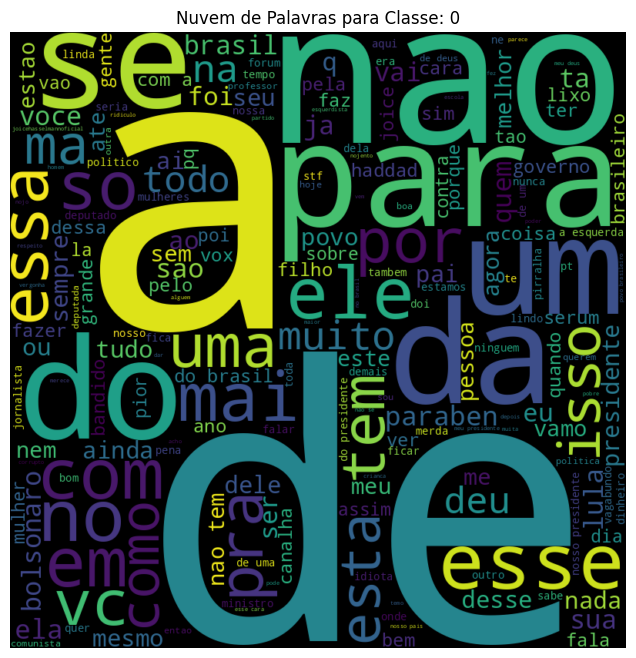

In [ ]:
# 2.2.1. Data Exploration & Visualization (Word Cloud)[80%]
import pandas as pd
import re
from sklearn.model_selection import train_test_split

classes = df['label'].unique()
random_class = classes[randrange(len(classes))]

#class_text = ' '.join(df[df['label_final'] == random_class]['comentario'])
class_text = ' '.join(df['text'])

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=800,
                         background_color='black',
                         stopwords="portuguese",
                         collocations=True).generate(class_text)

# Plotar
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Nuvem de Palavras para Classe: {random_class}')
plt.show()

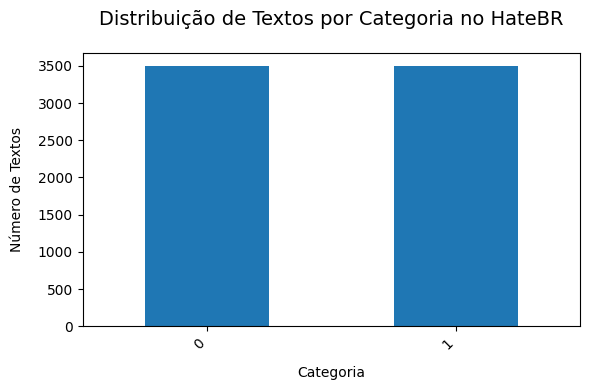

In [ ]:
# 2.2.2. Visualisation (Visualizing word count balance in bar chart) [99%]

category_column = 'label'

# Criando o gráfico
plt.figure(figsize=(6, 4))

# Contando os textos por categoria e plotando
df.groupby(category_column).size().sort_values(ascending=False).plot.bar(color='#1f77b4')

# Adicionando título e labels
plt.title("Distribuição de Textos por Categoria no HateBR", pad=20, fontsize=14)
plt.xlabel("Categoria", labelpad=10)
plt.ylabel("Número de Textos", labelpad=10)
plt.xticks(rotation=45, ha='right')

# Ajustando layout para não cortar rótulos
plt.tight_layout()

# Mostrando o gráfico
plt.show()

In [ ]:
# 3. TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))

In [ ]:
from sklearn.metrics import f1_score
# 4.1. Classification (Model Trainer) [99%]
# Fit the TF-IDF vectorizer on the training data and transform
X_train_vectorized = tfidf_vectorizer.fit_transform(text_train)
X_test_vectorized = tfidf_vectorizer.transform(text_test)


# Multinomial Naive Bayes
mnb = MultinomialNB().fit(X_train_vectorized, label_train)
y_pred_mnb = mnb.predict(X_test_vectorized)
print(f"Naive Bayes\nAccuracy: {accuracy_score(label_test, y_pred_mnb):.2f}\nF1-Score : {f1_score(label_test, y_pred_rf):.2f}")
print("\n-----\n")
# Random Forest
rf = RandomForestClassifier().fit(X_train_vectorized, label_train)
y_pred_rf = rf.predict(X_test_vectorized)
print(f"Random Forest\nAccuracy: {accuracy_score(label_test, y_pred_rf):.2f}\nF1-Score : {f1_score(label_test, y_pred_rf):.2f}")

Naive Bayes
Accuracy: 0.82
F1-Score : 0.79

-----

Random Forest
Accuracy: 0.79
F1-SCore : 0.79


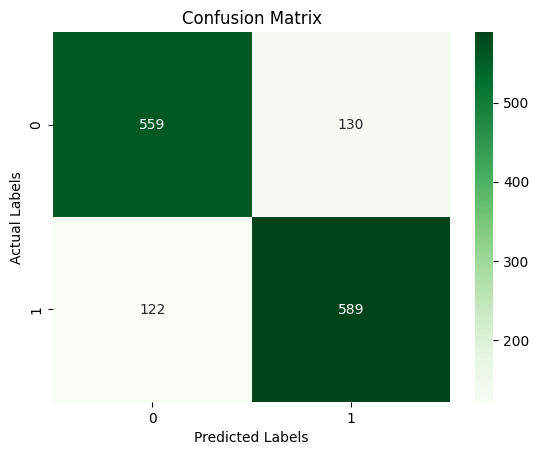

In [ ]:
# 5. Analysis (Matriz) [30% ainda não analisei se funciona mesmo]
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_metrics = confusion_matrix(label_test, y_pred_mnb)

class_names = np.unique(np.concatenate((label_test, y_pred_mnb)))
sns.heatmap(confusion_metrics, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
# 4.2 Classification (Exemple Prediction) [0% ainda não testei nem estudei]
teste = tfidf_vectorizer.transform(["Você é um lindo"])
rf.predict(teste)

array([0])

In [ ]:
# 4.2 Classification (Exemple Prediction) [0% ainda não testei nem estudei]
teste = tfidf_vectorizer.transform(["Você é um bosta"])
rf.predict(teste)

array([1])